In [ ]:
import sys
import Library.Utility as utility
import Library.AdamWR.adamw as adamw
import Library.AdamWR.cyclic_scheduler as cyclic_scheduler
import PAE as model
import Plotting as plot

import numpy as np
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn as nn
import random

import matplotlib.pyplot as plt

In [1]:
Load = "Dataset"
Save = "Training"

In [9]:
# Start Parameter Section
window = 2.0  # time duration of the time window
fps = 60  # fps of the motion capture data
joints = 75  # 26  # joints of the character skeleton

frames = int(window * fps) + 1
input_channels = 3 * joints  # number of channels along time in the input data (here 3*J as XYZ-component of each joint)
phase_channels = 5  # desired number of latent phase channels (usually between 2-10)

epochs = 3
batch_size = 3200
learning_rate = 1e-4
weight_decay = 1e-4
restart_period = 10
restart_mult = 2

plotting_interval = 500  # update visualization at every n-th batch (visualization only)
pca_sequence_count = 100  # number of motion sequences visualized in the PCA (visualization only)
test_sequence_ratio = 0.01  # ratio of randomly selected test sequences (visualization only)

In [5]:
Data = Load + "/Data.bin"
Shape = utility.LoadTxtAsInt(Load + "/DataShape.txt")
Sequences = utility.LoadSequences(Load + "/Sequences.txt", True, Shape[0])

Loading Dataset/DataShape.txt
Loading Dataset/Sequences.txt


In [10]:
sample_count = Shape[0]
feature_dim = Shape[1]
gather_padding = (int((frames - 1) / 2))
gather_window = np.arange(frames) - gather_padding

### End Parameter Section

In [11]:

def LoadBatches(sequences):
    gather = gather_window.reshape(1, -1).repeat(sequences.shape[0], 0)

    sequences = data_sequences[sequences]

    pivot = sequences[:, 0].reshape(-1, 1)
    min = sequences[:, 1].reshape(-1, 1)
    max = sequences[:, 2].reshape(-1, 1)

    gather = np.clip(gather + pivot, min, max)

    shape = gather.shape

    batch = utility.ReadBatchFromMatrix(Data, gather.flatten())

    batch = batch.reshape(shape[0], shape[1], -1)
    batch = batch.swapaxes(1, 2)
    batch = batch.reshape(shape[0], batch.shape[1] * batch.shape[2])
    return batch

In [15]:
# Start Generate Data Sequences
print("Generating Data Sequences")
data_sequences = []
test_sequences = []

for i in range(Sequences[-1]):
    utility.PrintProgress(i, Sequences[-1])
    indices = np.where(Sequences == (i + 1))[0]
    for j in range(indices.shape[0]):
        slice = [indices[j], indices[0], indices[-1]]
        data_sequences.append(slice)
        if np.random.uniform(0, 1) < test_sequence_ratio and indices[j] >= (indices[0] + gather_padding) and indices[j] <= (indices[-1] - gather_padding):
            test_sequences.append(j)

Generating Data Sequences


## Read data

In [16]:
Data = utility.ReadBinary(Data, sample_count, feature_dim)

Reading binary Dataset/Data.bin... 100 % %


In [17]:
print("Data Sequences:", len(data_sequences))
print("Test Sequences:", len(test_sequences))
data_sequences = np.array(data_sequences)
sample_count = len(data_sequences)
# End Generate Data Sequences

# Initialize all seeds
seed = 23456
rng = np.random.RandomState(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.mps.manual_seed(seed)
torch.backends.cudnn.deterministic = True

Data Sequences: 46114
Test Sequences: 441


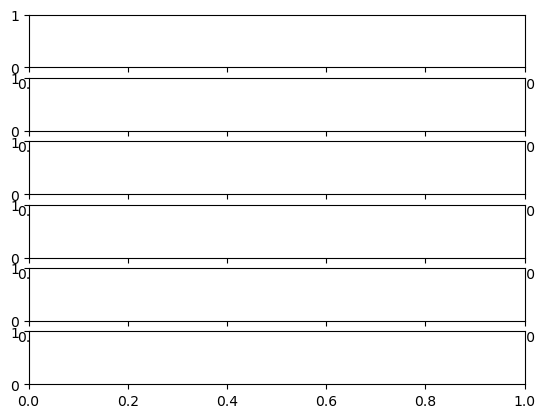

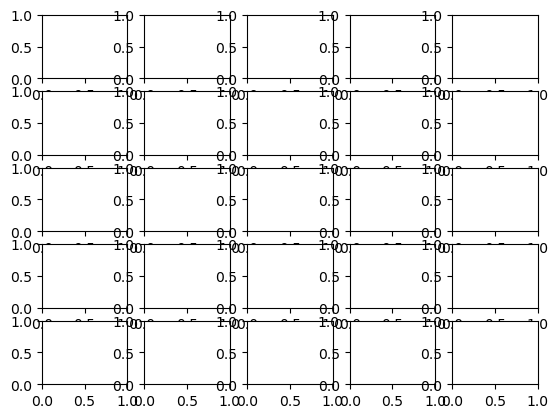

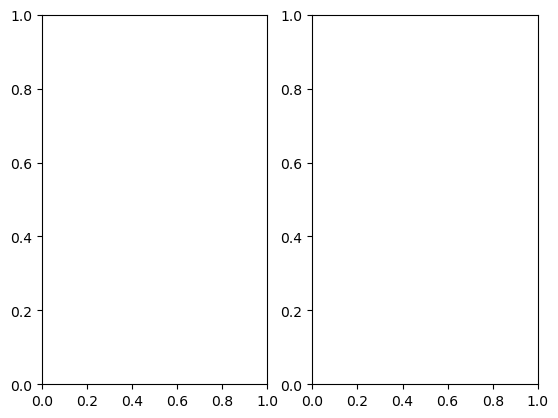

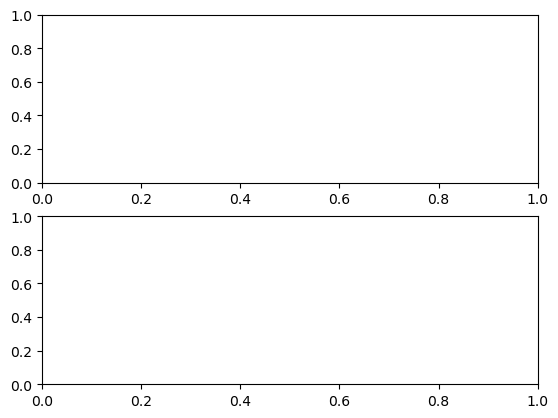

In [18]:
# Initialize drawing
plt.ion()
fig1, ax1 = plt.subplots(6, 1)
fig2, ax2 = plt.subplots(phase_channels, 5)
fig3, ax3 = plt.subplots(1, 2)
fig4, ax4 = plt.subplots(2, 1)
dist_amps = []
dist_freqs = []
loss_history = utility.PlottingWindow("Loss History", ax=ax4, min=0, drawInterval=plotting_interval)

## Build network model

In [19]:
network = utility.ToDevice(model.Model(
    input_channels=input_channels,
    embedding_channels=phase_channels,
    time_range=frames,
    window=window
))

## Setup optimizer and loss function
    

In [21]:
optimizer = adamw.AdamW(network.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = cyclic_scheduler.CyclicLRWithRestarts(optimizer=optimizer, batch_size=batch_size, epoch_size=sample_count, restart_period=restart_period, t_mult=restart_mult, policy="cosine", verbose=True)
loss_function = torch.nn.MSELoss()

In [24]:
I = np.arange(sample_count)

In [25]:
i = 0

train_indices = I[i:i + batch_size]

In [26]:
train_batch = LoadBatches(train_indices)

In [29]:
np.shape(train_batch)

torch.Size([3200, 27225])

In [30]:
train_data = train_batch.reshape(train_batch.shape[0], 225, 121)
np.shape(train_data)

torch.Size([3200, 225, 121])

torch.Size([10, 800])

In [50]:
def visualize_lines(data):
    # Assuming data is of shape (lines, timestamps), where timestamps is the x-axis
    num_lines, num_timestamps = data.shape

    # Create a figure for plotting
    plt.figure(figsize=(10, 6))

    # Plot each line across the timestamps
    for i in range(num_lines):
        plt.plot(range(num_timestamps), data[i], label=f'Line {i + 1}')

    plt.title('Line Visualization over Time')
    plt.xlabel('Timestamps')
    plt.ylabel('Values')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1), ncol=1, fontsize='small')
    plt.show()


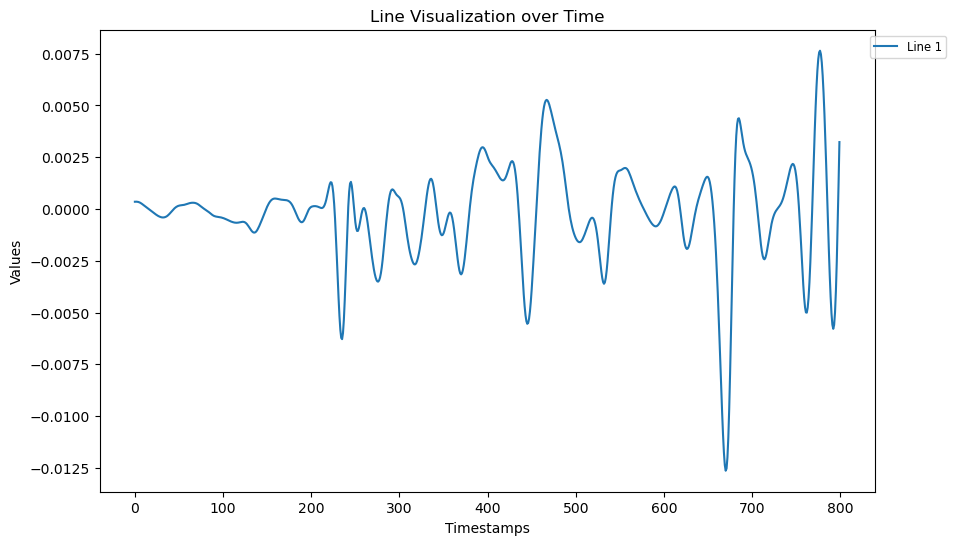

In [54]:
train_data_sample = train_data[200:1000, 1, :1].T
train_data_sample.shape
visualize_lines(train_data_sample.cpu())

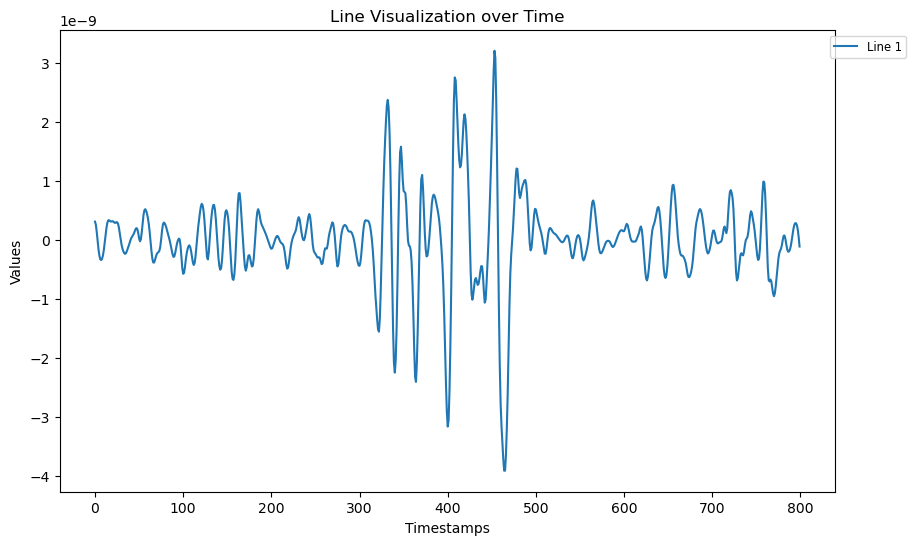

In [58]:
train_data_sample = train_data[200:1000, 0, :1].T
train_data_sample.shape
visualize_lines(train_data_sample.cpu())

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


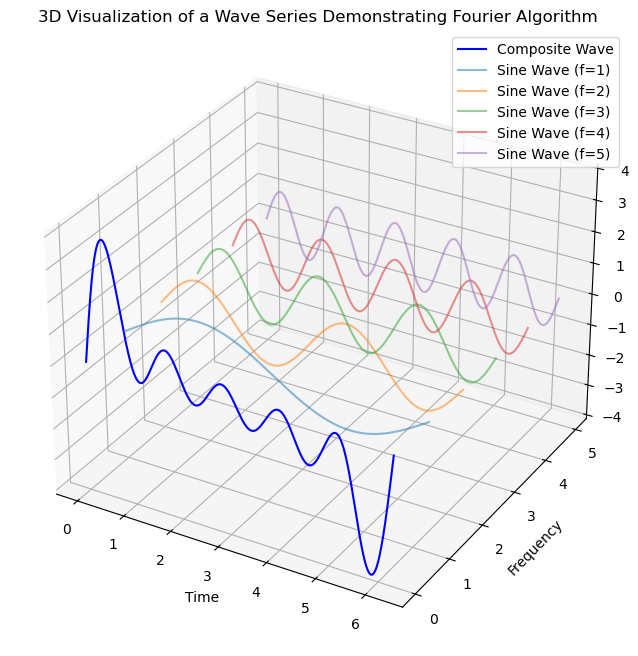

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a figure and a 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create time variable
t = np.linspace(0, 2 * np.pi, 1000)  # Time variable

# Frequencies of the sine waves
frequencies = [1, 2, 3, 4, 5]  # Frequencies to include in the Fourier series

# Generate the composite wave
y = np.zeros_like(t)
for frequency in frequencies:
    y += np.sin(frequency * t)  # Sum sine waves of different frequencies

# Create a meshgrid for the Fourier visualization
T, F = np.meshgrid(t, frequencies)
Z = np.sin(F * T)  # Create a grid of sine waves

# Plot the combined wave
ax.plot(t, y, zs=0, zdir='y', label='Composite Wave', color='blue')

# Plot the individual frequency components
for frequency in frequencies:
    ax.plot(t, np.sin(frequency * t), zs=frequency, zdir='y', alpha=0.5, label=f'Sine Wave (f={frequency})')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Amplitude')
ax.set_title('3D Visualization of a Wave Series Demonstrating Fourier Algorithm')
ax.legend()

# Show the plot
plt.show()


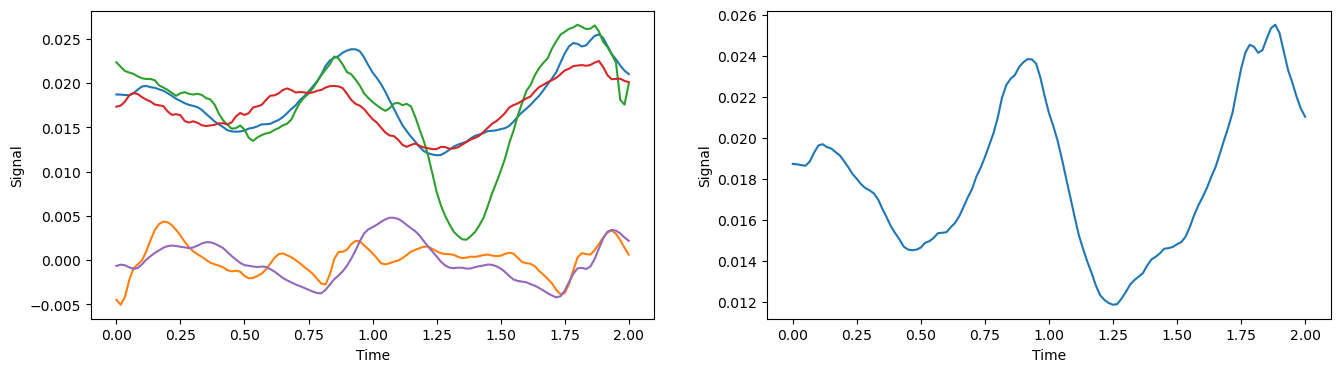

In [7]:
import numpy as np
import matplotlib.pyplot as plt

"""
First we need some data for visualisation

These signals were takes from mocap data in fewshot_database.npz from
https://github.com/ianxmason/Fewshot_Learning_of_Homogeneous_Human_Locomotion_Styles

with open('fewshot_database.npz', 'rb') as f:
    data = np.load(f)['Xin']
    w = ((60 * 2) // 10)
    data = data[:, w * 56:]  # pos and vel for 31 joints
    start = 300
    end = start + 121
    signal_one = data[start:end, 95]
    signal_two = data[start:end, 100]
    signal_three = data[start:end, 179]
    signal_four = data[start:end, 140]
    signal_five = data[start:end, 35]
"""

signal_one = [0.01872, 0.0187, 0.01866, 0.01863, 0.01884, 0.01927, 0.01962, 0.01968, 0.01954, 0.01947, 0.0193, 0.01914,
              0.01886, 0.01856, 0.01823, 0.01799, 0.01773, 0.01754, 0.01743, 0.01728, 0.01698, 0.01652, 0.01611,
              0.01567, 0.01534, 0.01503, 0.01468, 0.01454, 0.01451, 0.01454, 0.01464, 0.01487, 0.01495, 0.01511,
              0.01534, 0.01536, 0.01539, 0.01563, 0.01584, 0.01617, 0.01662, 0.01709, 0.0175, 0.0181, 0.01853, 0.01905,
              0.01963, 0.02021, 0.02097, 0.02195, 0.02256, 0.02287, 0.02305, 0.02344, 0.02368, 0.02383, 0.02382,
              0.02361, 0.02292, 0.02202, 0.0212, 0.02058, 0.01987, 0.019, 0.01803, 0.0171, 0.01615, 0.01524, 0.01457,
              0.01394, 0.01339, 0.01278, 0.01231, 0.01208, 0.01193, 0.01185, 0.01188, 0.01215, 0.01247, 0.01283,
              0.01305, 0.01322, 0.01339, 0.01376, 0.01406, 0.01419, 0.01436, 0.01458, 0.01461, 0.01467, 0.0148,
              0.01491, 0.01517, 0.01565, 0.01622, 0.0167, 0.01711, 0.01755, 0.01808, 0.01856, 0.0192, 0.01987,
              0.02051, 0.02123, 0.02231, 0.02336, 0.02415, 0.02453, 0.02444, 0.02414, 0.02427, 0.02483, 0.02534,
              0.02551, 0.0251, 0.0242, 0.0233, 0.02268, 0.02199, 0.02141, 0.02102]
signal_two = [-0.00448, -0.00504, -0.00417, -0.00226, -0.00092, -0.00049, -3e-05, 0.00099, 0.00226, 0.0034, 0.00408,
              0.00435, 0.00428, 0.00395, 0.00341, 0.00278, 0.00206, 0.00146, 0.00098, 0.00067, 0.00037, 3e-05, -0.00029,
              -0.00047, -0.00062, -0.00082, -0.00113, -0.00127, -0.00119, -0.00131, -0.00179, -0.00206, -0.00201,
              -0.0018, -0.00154, -0.00106, -0.00042, 0.00024, 0.00068, 0.00076, 0.00054, 0.00032, 0.0, -0.00036,
              -0.00078, -0.00113, -0.00156, -0.00211, -0.00266, -0.00274, -0.0016, 1e-04, 0.00091, 0.00095, 0.00118,
              0.00181, 0.00216, 0.00213, 0.00167, 0.00124, 0.00078, 0.00022, -0.00037, -0.00048, -0.00035, -0.00017,
              -5e-05, 0.00022, 0.00059, 0.00096, 0.00116, 0.00135, 0.00152, 0.00153, 0.00127, 0.001, 0.00078, 0.00069,
              0.00067, 0.0006, 0.00037, 0.00023, 0.00028, 0.00039, 0.00037, 0.00046, 0.00058, 0.00063, 0.00051, 0.00045,
              0.00049, 0.0007, 0.00084, 0.00073, 0.00026, -0.00021, -0.00034, -0.00042, -0.00069, -0.00122, -0.00164,
              -0.00211, -0.00263, -0.00335, -0.00385, -0.00372, -0.0027, -0.00114, 0.0003, 0.00079, 0.00068, 0.00062,
              0.00113, 0.00182, 0.00254, 0.00312, 0.00334, 0.00298, 0.00225, 0.00139, 0.00062]
signal_three = [0.02235, 0.02185, 0.02137, 0.0212, 0.02104, 0.02077, 0.02055, 0.02047, 0.02047, 0.02032, 0.01975,
                0.0195, 0.01924, 0.01888, 0.01857, 0.01886, 0.01898, 0.01879, 0.01871, 0.01879, 0.01867, 0.0183,
                0.01816, 0.01757, 0.01655, 0.01578, 0.01532, 0.01485, 0.01492, 0.01521, 0.01475, 0.01382, 0.01347,
                0.01386, 0.01412, 0.01431, 0.01442, 0.01471, 0.01492, 0.01523, 0.01542, 0.0159, 0.01693, 0.01781,
                0.01838, 0.01882, 0.01942, 0.02015, 0.02091, 0.02154, 0.02214, 0.02301, 0.02281, 0.0221, 0.02125, 0.021,
                0.02041, 0.01973, 0.01885, 0.01832, 0.01787, 0.01749, 0.01714, 0.01687, 0.01717, 0.01769, 0.01777,
                0.01751, 0.01766, 0.01736, 0.01617, 0.01477, 0.01344, 0.01181, 0.00979, 0.0077, 0.00619, 0.00499,
                0.00405, 0.00321, 0.00274, 0.00235, 0.00231, 0.00272, 0.00318, 0.00394, 0.0048, 0.00614, 0.00756,
                0.00877, 0.01007, 0.01146, 0.01322, 0.01462, 0.01633, 0.01775, 0.01911, 0.01979, 0.0209, 0.0217,
                0.02229, 0.0228, 0.0239, 0.02472, 0.02548, 0.0258, 0.02613, 0.0263, 0.0266, 0.02636, 0.02611, 0.02615,
                0.02652, 0.02584, 0.02467, 0.02409, 0.02325, 0.02232, 0.01811, 0.01757, 0.01998]
signal_four = [0.01734, 0.01746, 0.01791, 0.01862, 0.01889, 0.01877, 0.01841, 0.01814, 0.01792, 0.01758, 0.01749,
               0.0174, 0.0168, 0.01641, 0.01649, 0.01638, 0.01572, 0.01554, 0.01569, 0.01552, 0.01524, 0.01515, 0.01522,
               0.01529, 0.01545, 0.01547, 0.01533, 0.01557, 0.01624, 0.01663, 0.0164, 0.01661, 0.01725, 0.01738,
               0.01753, 0.01807, 0.01857, 0.01862, 0.01884, 0.01923, 0.0194, 0.01921, 0.01894, 0.01899, 0.01896,
               0.01886, 0.01895, 0.01913, 0.01923, 0.0195, 0.01966, 0.01968, 0.01963, 0.01944, 0.0188, 0.0181, 0.01766,
               0.01745, 0.01707, 0.01648, 0.01592, 0.01554, 0.01496, 0.01441, 0.01409, 0.01401, 0.01359, 0.01303,
               0.0128, 0.01302, 0.01318, 0.01292, 0.01274, 0.01264, 0.01255, 0.01255, 0.01279, 0.01277, 0.01259,
               0.01262, 0.01275, 0.01305, 0.01335, 0.01364, 0.01381, 0.01406, 0.0145, 0.01496, 0.01542, 0.01571,
               0.01614, 0.01661, 0.01725, 0.01752, 0.01771, 0.01799, 0.01827, 0.0185, 0.01908, 0.01955, 0.01981,
               0.02011, 0.02033, 0.02059, 0.021, 0.02143, 0.02163, 0.02192, 0.02199, 0.02204, 0.02196, 0.02205,
               0.02232, 0.0225, 0.02182, 0.0209, 0.02044, 0.02048, 0.0205, 0.02025, 0.02011]
signal_five = [-0.00066, -0.00051, -0.00058, -0.00081, -0.00099, -0.00089, -0.00048, 5e-05, 0.00045, 0.00081, 0.00111,
               0.0014, 0.00158, 0.00165, 0.00159, 0.00151, 0.00144, 0.00136, 0.00143, 0.00164, 0.00188, 0.00202, 0.00202,
               0.00186, 0.00163, 0.00136, 0.00091, 0.00046, 6e-05, -0.00031, -0.00057, -0.00064, -0.00072, -0.00078,
               -0.00073, -0.00076, -0.001, -0.00129, -0.00165, -0.00202, -0.00229, -0.00252, -0.00276, -0.00294,
               -0.00314, -0.00335, -0.00355, -0.00372, -0.00375, -0.00335, -0.00276, -0.00217, -0.00175, -0.00126,
               -0.00063, 0.00017, 0.00109, 0.00213, 0.00301, 0.00348, 0.00372, 0.004, 0.00433, 0.00461, 0.00479, 0.00478,
               0.00466, 0.00436, 0.00397, 0.00361, 0.00326, 0.00278, 0.00214, 0.00153, 0.00098, 0.00041, -0.00017,
               -0.00061, -0.00085, -0.00091, -0.00085, -0.00086, -0.00096, -0.00094, -0.00079, -0.00069, -0.0006,
               -0.0005, -0.00053, -0.0007, -0.00095, -0.00133, -0.00179, -0.00219, -0.00235, -0.00243, -0.0025, -0.00271,
               -0.0029, -0.00315, -0.00343, -0.00374, -0.004, -0.00421, -0.00409, -0.00345, -0.00249, -0.00154, -0.00093,
               -0.00087, -0.00101, -0.00073, 0.00013, 0.0013, 0.00245, 0.00321, 0.00342, 0.00333, 0.00302, 0.00256,
               0.00217]

signal = signal_one
time_window = 2
num_samples = 121
samples = np.linspace(0, time_window, num_samples)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(samples, signal_one)
ax1.plot(samples, signal_two)
ax1.plot(samples, signal_three)
ax1.plot(samples, signal_four)
ax1.plot(samples, signal_five)
ax1.set_xlabel('Time')
ax1.set_ylabel('Signal')
ax2.plot(samples, signal)
ax2.set_xlabel('Time')
ax2.set_ylabel('Signal')
plt.savefig('latent_signals.png', bbox_inches='tight')


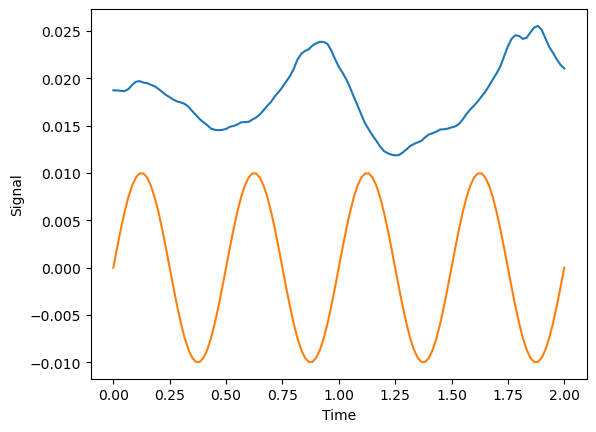

In [8]:

A = 0.01
F = 2
B = 0
P = 0
function = A * np.sin(2 * np.pi * (F * samples - P)) + B
plt.clf()
plt.plot(samples, signal)
plt.plot(samples, function)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.savefig('chosen_signal.png', bbox_inches='tight')


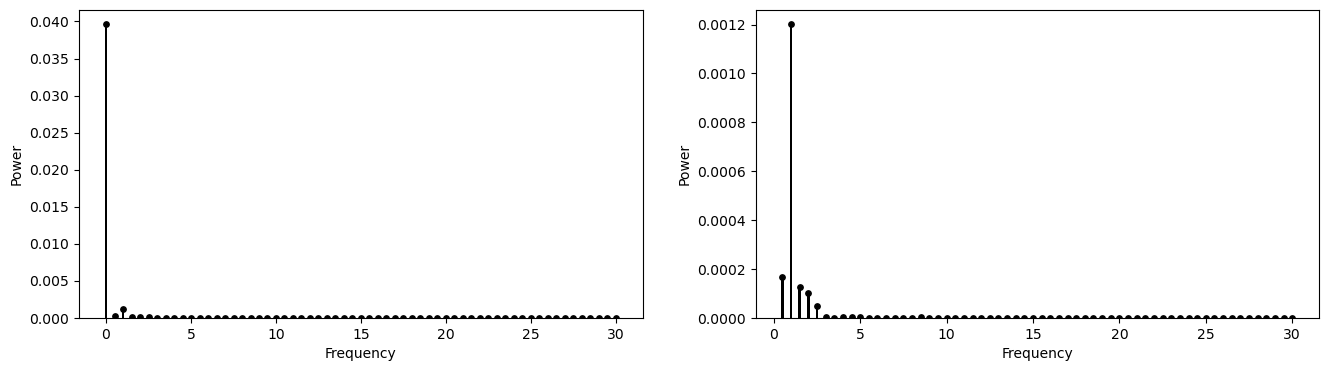

In [9]:

# Do dft
rfft = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(num_samples, d=time_window / num_samples)

# Power spectrum
power = 2 * np.abs(rfft) ** 2 / num_samples
power[0] = power[0] / 2.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.bar(freqs[0:], power[0:], width=0.15, color='k')
ax1.scatter(freqs[0:], power[0:], color='k', s=15)
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
ax2.bar(freqs[1:], power[1:], width=0.15, color='k')
ax2.scatter(freqs[1:], power[1:], color='k', s=15)
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')
plt.savefig('power_spectrum.png', bbox_inches='tight')


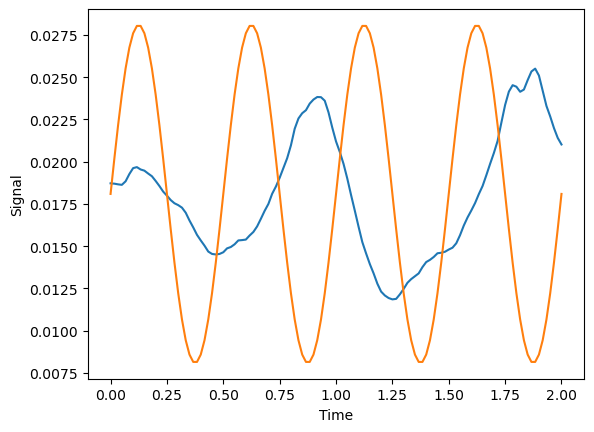

In [10]:

B = rfft[0].real / num_samples
function = A * np.sin(2 * np.pi * (F * samples - P)) + B
plt.clf()
plt.plot(samples, signal)
plt.plot(samples, function)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.savefig('signal_with_B.png', bbox_inches='tight')


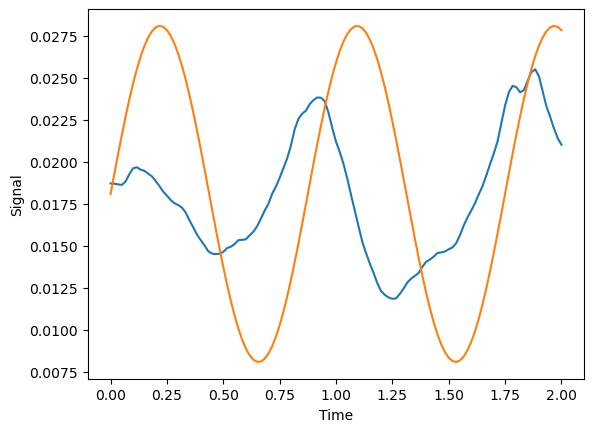

In [11]:

power = power[1:]
freqs = freqs[1:]
F = np.dot(freqs, power) / np.sum(power)
function = A * np.sin(2 * np.pi * (F * samples - P)) + B
plt.clf()
plt.plot(samples, signal)
plt.plot(samples, function)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.savefig('signal_with_F_B.png', bbox_inches='tight')


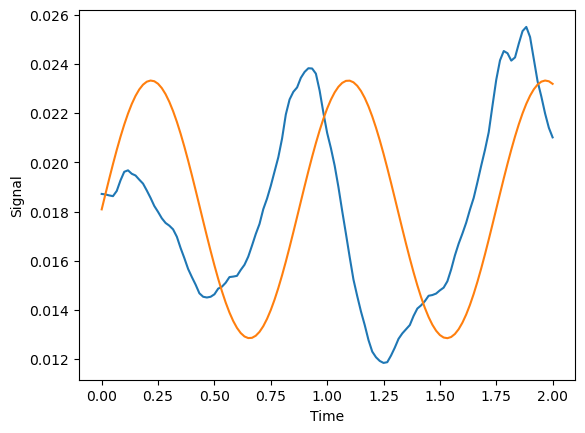

In [12]:

A = np.sqrt(2 / num_samples * np.sum(power))
function = A * np.sin(2 * np.pi * (F * samples - P)) + B
plt.clf()
plt.plot(samples, signal)
plt.plot(samples, function)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.savefig('signal_with_A_F_B.png', bbox_inches='tight')


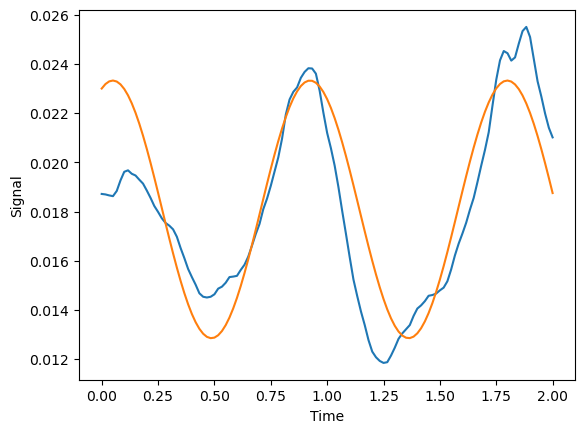

In [13]:

# New formula
P = np.arctan2(np.sum((signal - B) * np.sin(2 * np.pi * F * samples)),
               np.sum((signal - B) * np.cos(2 * np.pi * F * samples)))
plt.clf()
plt.plot(samples, signal)
plt.plot(samples, A * np.cos(2 * np.pi * F * samples - P) + B)
plt.xlabel('Time')
plt.ylabel('Signal')
plt.savefig('reconstructed_signal.png', bbox_inches='tight')


In [14]:

# Simple conversion to work with the chosen formulation
P = (P - np.pi / 2.) / (2 * np.pi)
# function = A * np.sin(2 * np.pi * (F * samples - P)) + B
# plt.clf()
# plt.plot(samples, signal)
# plt.plot(samples, function, 'g')
# plt.xlabel('Time')
# plt.ylabel('Signal')
# plt.show()

print("Found Offset: {}".format(B))
print("Found Frequency: {}".format(F))
print("Found Amplitude: {}".format(A))
print("Found Phase: {}".format(P))




Found Offset: 0.01809289256198347
Found Frequency: 1.14310003623132
Found Amplitude: 0.005237818433647379
Found Phase: -0.19360197358351325


"\nTo see the discontinuity in the phase spectrum try this plot for a simple function with endpoint=False & endpoint=True\n\ntime_window = 2\nnum_samples = 121\nsamples = np.linspace(0, time_window, num_samples, endpoint=False)\nmy_cosine = np.cos(2 * np.pi * samples)\nplt.plot(samples, my_cosine)\nplt.show()\n\n# Do dft\nrfft = np.fft.rfft(my_cosine)\nfreqs = np.fft.rfftfreq(num_samples, d=time_window / num_samples)\n\nphase = np.arctan2(rfft.imag[1:], rfft.real[1:]) / (2 * np.pi) * 360\nplt.clf()\nplt.plot(freqs[1:], phase, c='g')\nplt.scatter(freqs[1:], phase, c='g', s=15)\nplt.xlabel('Frequency')\nplt.ylabel('Phase')\nplt.show()\n"

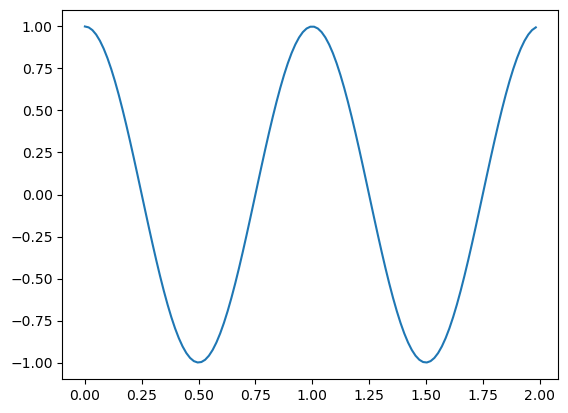

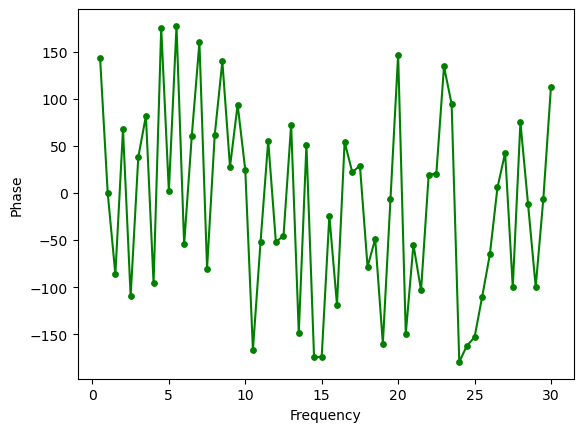

In [15]:
"""
To see the discontinuity in the phase spectrum try this plot for a simple function with endpoint=False & endpoint=True
"""

time_window = 2
num_samples = 121
samples = np.linspace(0, time_window, num_samples, endpoint=False)
my_cosine = np.cos(2 * np.pi * samples)
plt.plot(samples, my_cosine)
plt.show()

# Do dft
rfft = np.fft.rfft(my_cosine)
freqs = np.fft.rfftfreq(num_samples, d=time_window / num_samples)

phase = np.arctan2(rfft.imag[1:], rfft.real[1:]) / (2 * np.pi) * 360
plt.clf()
plt.plot(freqs[1:], phase, c='g')
plt.scatter(freqs[1:], phase, c='g', s=15)
plt.xlabel('Frequency')
plt.ylabel('Phase')
plt.show()

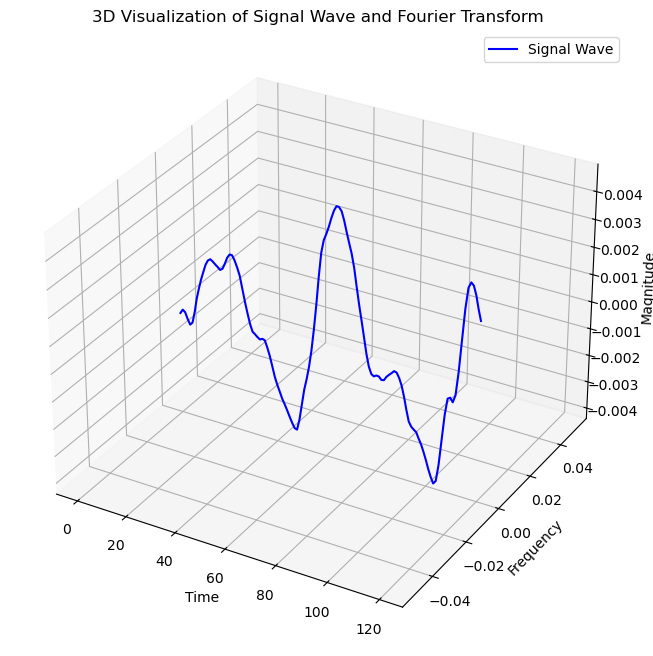

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Given signal wave data
signal_wave = [
    -0.00066, -0.00051, -0.00058, -0.00081, -0.00099, -0.00089, -0.00048, 5e-05, 0.00045,
    0.00081, 0.00111, 0.0014, 0.00158, 0.00165, 0.00159, 0.00151, 0.00144, 0.00136,
    0.00143, 0.00164, 0.00188, 0.00202, 0.00202, 0.00186, 0.00163, 0.00136, 0.00091,
    0.00046, 6e-05, -0.00031, -0.00057, -0.00064, -0.00072, -0.00078, -0.00073, 
    -0.00076, -0.001, -0.00129, -0.00165, -0.00202, -0.00229, -0.00252, -0.00276,
    -0.00294, -0.00314, -0.00335, -0.00355, -0.00372, -0.00375, -0.00335, -0.00276,
    -0.00217, -0.00175, -0.00126, -0.00063, 0.00017, 0.00109, 0.00213, 0.00301,
    0.00348, 0.00372, 0.004, 0.00433, 0.00461, 0.00479, 0.00478, 0.00466, 0.00436,
    0.00397, 0.00361, 0.00326, 0.00278, 0.00214, 0.00153, 0.00098, 0.00041, 
    -0.00017, -0.00061, -0.00085, -0.00091, -0.00085, -0.00086, -0.00096, 
    -0.00094, -0.00079, -0.00069, -0.0006, -0.0005, -0.00053, -0.0007, 
    -0.00095, -0.00133, -0.00179, -0.00219, -0.00235, -0.00243, -0.0025, 
    -0.00271, -0.0029, -0.00315, -0.00343, -0.00374, -0.004, -0.00421, 
    -0.00409, -0.00345, -0.00249, -0.00154, -0.00093, -0.00087, -0.00101,
    -0.00073, 0.00013, 0.0013, 0.00245, 0.00321, 0.00342, 0.00333, 
    0.00302, 0.00256, 0.00217
]

# Create a time variable based on the length of the signal
t = np.arange(len(signal_wave))

# Perform Fourier Transform
frequencies = np.fft.fftfreq(len(signal_wave), d=1)
fourier_transform = np.fft.fft(signal_wave)

# Create the figure for 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the frequency representation
T, F = np.meshgrid(t, frequencies[:len(frequencies)//2])
Z = np.abs(fourier_transform[:len(fourier_transform)//2])  # Magnitude of the Fourier Transform

# Plot the time-domain signal
ax.plot(t, signal_wave, zs=0, zdir='y', label='Signal Wave', color='blue')

# Plot the Fourier Transform
# ax.plot_surface(T, F, Z, alpha=0.5, rstride=100, cstride=100, color='red')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Magnitude')
ax.set_title('3D Visualization of Signal Wave and Fourier Transform')
ax.legend()

# Show the plot
plt.show()


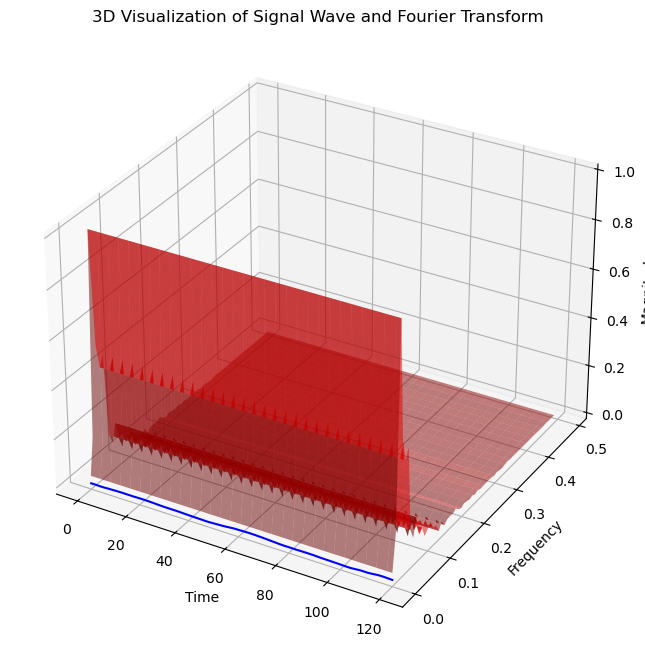

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Given signal wave data
signal_wave = [
    -0.00066, -0.00051, -0.00058, -0.00081, -0.00099, -0.00089, -0.00048, 5e-05, 0.00045,
    0.00081, 0.00111, 0.0014, 0.00158, 0.00165, 0.00159, 0.00151, 0.00144, 0.00136,
    0.00143, 0.00164, 0.00188, 0.00202, 0.00202, 0.00186, 0.00163, 0.00136, 0.00091,
    0.00046, 6e-05, -0.00031, -0.00057, -0.00064, -0.00072, -0.00078, -0.00073, 
    -0.00076, -0.001, -0.00129, -0.00165, -0.00202, -0.00229, -0.00252, -0.00276,
    -0.00294, -0.00314, -0.00335, -0.00355, -0.00372, -0.00375, -0.00335, -0.00276,
    -0.00217, -0.00175, -0.00126, -0.00063, 0.00017, 0.00109, 0.00213, 0.00301,
    0.00348, 0.00372, 0.004, 0.00433, 0.00461, 0.00479, 0.00478, 0.00466, 0.00436,
    0.00397, 0.00361, 0.00326, 0.00278, 0.00214, 0.00153, 0.00098, 0.00041, 
    -0.00017, -0.00061, -0.00085, -0.00091, -0.00085, -0.00086, -0.00096, 
    -0.00094, -0.00079, -0.00069, -0.0006, -0.0005, -0.00053, -0.0007, 
    -0.00095, -0.00133, -0.00179, -0.00219, -0.00235, -0.00243, -0.0025, 
    -0.00271, -0.0029, -0.00315, -0.00343, -0.00374, -0.004, -0.00421, 
    -0.00409, -0.00345, -0.00249, -0.00154, -0.00093, -0.00087, -0.00101,
    -0.00073, 0.00013, 0.0013, 0.00245, 0.00321, 0.00342, 0.00333, 
    0.00302, 0.00256, 0.00217
]

# Create a time variable based on the length of the signal
t = np.arange(len(signal_wave))

# Perform Fourier Transform
fourier_transform = np.fft.fft(signal_wave)
frequencies = np.fft.fftfreq(len(signal_wave), d=1)

# Create the figure for 3D plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the time-domain signal
ax.plot(t, np.zeros_like(t), signal_wave, label='Signal Wave', color='blue')

# Prepare data for Fourier Transform visualization
Z = np.abs(fourier_transform)  # Magnitude of the Fourier Transform
Z_normalized = Z[:len(Z)//2] / np.max(Z)  # Normalize for better visualization
frequencies_positive = frequencies[:len(frequencies)//2]  # Positive frequencies only

# Create meshgrid for frequency representation
T = np.linspace(0, max(t), len(frequencies_positive))  # X values
F = frequencies_positive  # Y values
Z_surface = Z_normalized  # Z values

# Repeat the Z values to create a 2D surface
Z_surface_mesh = np.tile(Z_surface, (len(T), 1))

# Plot the Fourier Transform as a surface
ax.plot_surface(T[:, np.newaxis], F[np.newaxis, :], Z_surface_mesh, alpha=0.5, color='red')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('Frequency')
ax.set_zlabel('Magnitude')
ax.set_title('3D Visualization of Signal Wave and Fourier Transform')
ax.legend
# Show the plot
plt.show()


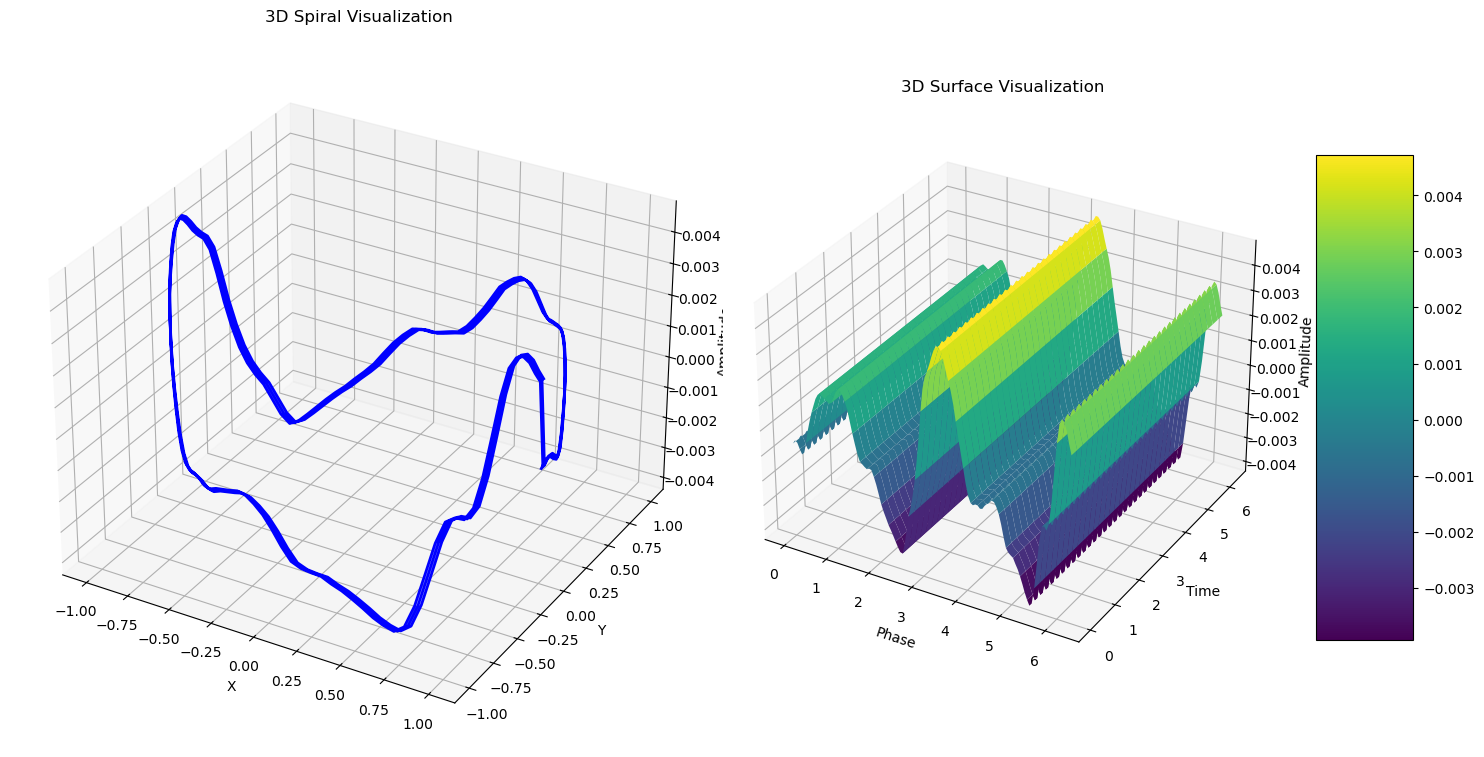

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_3d_wave_visualization(signal_wave, num_cycles=3, samples_per_cycle=None):
    """
    Create a 3D visualization of a wave signal with multiple display options
    
    Parameters:
    signal_wave (list): List of wave amplitude values
    num_cycles (int): Number of cycles to show in the 3D view
    samples_per_cycle (int): Number of samples per cycle (optional)
    """
    # Convert signal to numpy array
    signal = np.array(signal_wave)
    
    # Create time points
    t = np.arange(len(signal))
    
    # Create figure with subplots
    fig = plt.figure(figsize=(15, 10))
    
    # First subplot: 3D Line
    ax1 = fig.add_subplot(121, projection='3d')
    
    # Create spiral effect by repeating the signal
    repeated_signal = np.tile(signal, num_cycles)
    t_extended = np.arange(len(repeated_signal))
    
    # Create spiral coordinates
    theta = np.linspace(0, num_cycles * 2 * np.pi, len(repeated_signal))
    x = np.cos(theta)
    y = np.sin(theta)
    z = repeated_signal
    
    # Plot 3D spiral
    ax1.plot(x, y, z, linewidth=2, color='blue')
    
    # Customize first plot
    ax1.set_title('3D Spiral Visualization', pad=20)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Amplitude')
    
    # Second subplot: 3D Surface
    ax2 = fig.add_subplot(122, projection='3d')
    
    # Create 2D grid for surface plot
    X = np.linspace(0, 2*np.pi, len(signal))
    Y = np.linspace(0, 2*np.pi, num_cycles*10)
    X, Y = np.meshgrid(X, Y)
    
    # Create Z values (amplitude)
    Z = np.zeros_like(X)
    for i in range(Z.shape[0]):
        Z[i, :] = signal
    
    # Plot surface
    surf = ax2.plot_surface(X, Y, Z, cmap='viridis',
                           linewidth=0,
                           antialiased=True)
    
    # Customize second plot
    ax2.set_title('3D Surface Visualization', pad=20)
    ax2.set_xlabel('Phase')
    ax2.set_ylabel('Time')
    ax2.set_zlabel('Amplitude')
    
    # Add colorbar
    fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)
    
    # Adjust layout
    plt.tight_layout()
    
    return fig

# Example usage with your signal
signal_wave = [-0.00066, -0.00051, -0.00058, -0.00081, -0.00099, -0.00089, -0.00048, 5e-05, 0.00045, 
               0.00081, 0.00111, 0.0014, 0.00158, 0.00165, 0.00159, 0.00151, 0.00144, 0.00136, 
               0.00143, 0.00164, 0.00188, 0.00202, 0.00202, 0.00186, 0.00163, 0.00136, 0.00091, 
               0.00046, 6e-05, -0.00031, -0.00057, -0.00064, -0.00072, -0.00078, -0.00073, -0.00076,
               -0.001, -0.00129, -0.00165, -0.00202, -0.00229, -0.00252, -0.00276, -0.00294, -0.00314,
               -0.00335, -0.00355, -0.00372, -0.00375, -0.00335, -0.00276, -0.00217, -0.00175, -0.00126,
               -0.00063, 0.00017, 0.00109, 0.00213, 0.00301, 0.00348, 0.00372, 0.004, 0.00433, 0.00461,
               0.00479, 0.00478, 0.00466, 0.00436, 0.00397, 0.00361, 0.00326, 0.00278, 0.00214, 0.00153,
               0.00098, 0.00041, -0.00017, -0.00061, -0.00085, -0.00091, -0.00085, -0.00086, -0.00096,
               -0.00094, -0.00079, -0.00069, -0.0006, -0.0005, -0.00053, -0.0007, -0.00095, -0.00133,
               -0.00179, -0.00219, -0.00235, -0.00243, -0.0025, -0.00271, -0.0029, -0.00315, -0.00343,
               -0.00374, -0.004, -0.00421, -0.00409, -0.00345, -0.00249, -0.00154, -0.00093, -0.00087,
               -0.00101, -0.00073, 0.00013, 0.0013, 0.00245, 0.00321, 0.00342, 0.00333, 0.00302,
               0.00256, 0.00217]

# Create and display the visualization
fig = create_3d_wave_visualization(signal_wave)
plt.show()

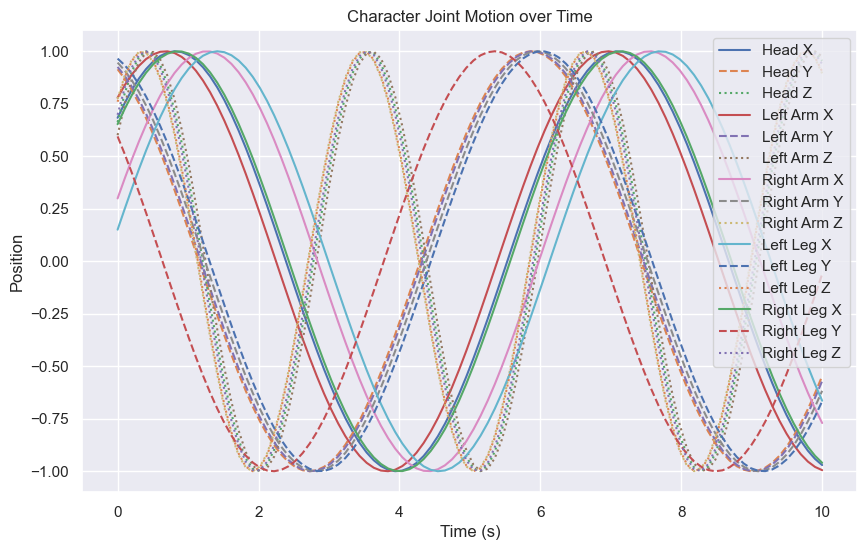

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Simulate some motion data for a character's joint positions (X, Y, Z) over time
time = np.linspace(0, 10, 100)  # 100 time steps
joint_names = ['Head', 'Left Arm', 'Right Arm', 'Left Leg', 'Right Leg']

# Generate random motion data for each joint's X, Y, Z positions
motion_data = {f'{joint}_X': np.sin(time + np.random.rand()) for joint in joint_names}
motion_data.update({f'{joint}_Y': np.cos(time + np.random.rand()) for joint in joint_names})
motion_data.update({f'{joint}_Z': np.sin(2 * time + np.random.rand()) for joint in joint_names})

# Convert to a DataFrame for easier plotting
motion_data['Time'] = time
df = pd.DataFrame(motion_data)

# Set Seaborn style for better aesthetics
sns.set(style="darkgrid")

# Plot X, Y, Z coordinates for each joint over time
plt.figure(figsize=(10, 6))
for joint in joint_names:
    sns.lineplot(x='Time', y=f'{joint}_X', data=df, label=f'{joint} X')
    sns.lineplot(x='Time', y=f'{joint}_Y', data=df, label=f'{joint} Y', linestyle='--')
    sns.lineplot(x='Time', y=f'{joint}_Z', data=df, label=f'{joint} Z', linestyle=':')

plt.title('Character Joint Motion over Time')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend(loc='upper right')
plt.show()
